# Watershed segmentation for droplet isolation

In [312]:
from math import sqrt

import numpy as np

import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import skimage
from skimage import io, exposure, img_as_float, img_as_ubyte, morphology, filters, util
from skimage.color import rgb2gray, label2rgb
from skimage.feature import canny, blob_dog, blob_log, blob_doh,  peak_local_max
from skimage.filters import sobel, threshold_otsu, try_all_threshold, threshold_local, threshold_minimum
from skimage.segmentation import clear_border, watershed, random_walker
from skimage.measure import label, regionprops
from skimage.measure import label, regionprops
from skimage.color import label2rgb
from skimage.morphology import closing

import cv2

from scipy import ndimage as ndi

import os

import plotly.graph_objs as go

### Read image

Read image as greyscale and color in parallel

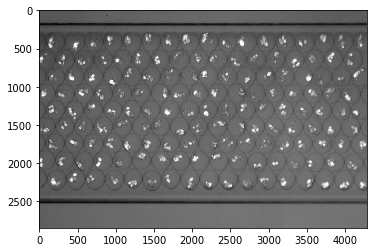

In [313]:
image_file = 'example_data/DSC_1074.JPG'
f_grey = cv2.imread(image_file, 0) # 0 reads as greyscale
f_color = cv2.imread(image_file, 1) # reads as color
plt.figure(0)
plt.imshow(f_grey, cmap=plt.cm.gray)

### Crop area of interest

and convert to uint (for some skimage methods)

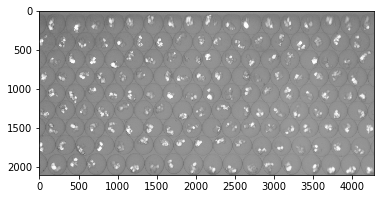

In [314]:
f_cropped = f_grey[250:2350,0:4288] #[lines, columns]
f_color_cropped = f_color[250:2350,0:4288] #[lines, columns]
plt.figure(2)
plt.imshow(f_cropped, cmap=plt.cm.gray, vmin=0, vmax=255)

In [315]:
f_cropped.shape

(2100, 4288)

### Increase contrast

Adaptive equalization can deal with some non-uniformity in the original image

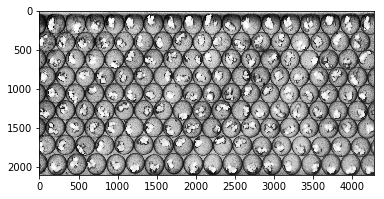

In [316]:
# Adaptive Equalization
clahe = cv2.createCLAHE(clipLimit=15, tileGridSize=(8,8))
img_adapteq = clahe.apply(f_cropped)
plt.imshow(img_adapteq, cmap=plt.cm.gray)


### Threshold

Otsu threshold was found to work best in this type of image (see SegmentationDropletsInCapillary).

Minimum threshold: 126.0
Min intensity: 0
Max intensity: 255


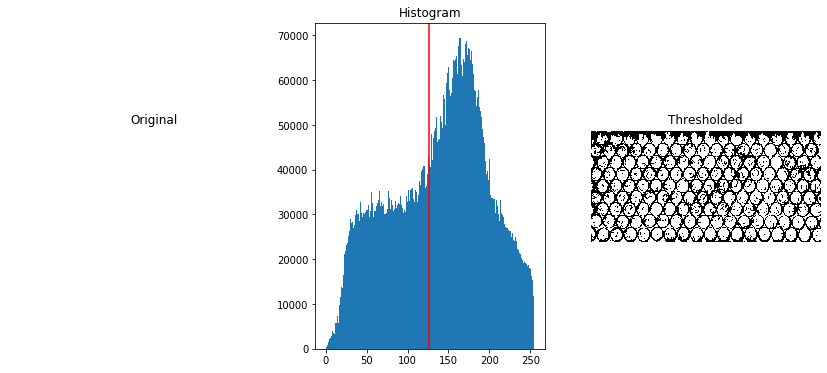

In [317]:
image = img_adapteq

blur = cv2.GaussianBlur(image,(5,5),0)
retVal, binary = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

fig, axes = plt.subplots(ncols=3, figsize=(14, 6))
ax = axes.ravel()
ax[0] = plt.subplot(1, 3, 1)
ax[1] = plt.subplot(1, 3, 2)
ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

ax[0].imshow(image, cmap=plt.cm.gray, vmin=0, vmax=1)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].hist(image.ravel(), bins=256)
ax[1].set_title('Histogram')
ax[1].axvline(retVal, color='r')

ax[2].imshow(binary, cmap=plt.cm.gray)
ax[2].set_title('Thresholded')
ax[2].axis('off')

print('Minimum threshold: ' + str(retVal))
print('Min intensity: ' + str(np.min(image)))
print('Max intensity: ' + str(np.max(image)))
plt.show()

### Perform Watershed segmentation

- Close to remove artifacts from contrast increase and thresholding
- Calculate the distance image, increase its contrast and mask low distance areas (at the intersection between drops)
- Find local distance maxima and use as markers for watershed
- Run the watershed algorithm to segment
- Label segmented regions

#### Closing and removing small dark spots from crystal borders

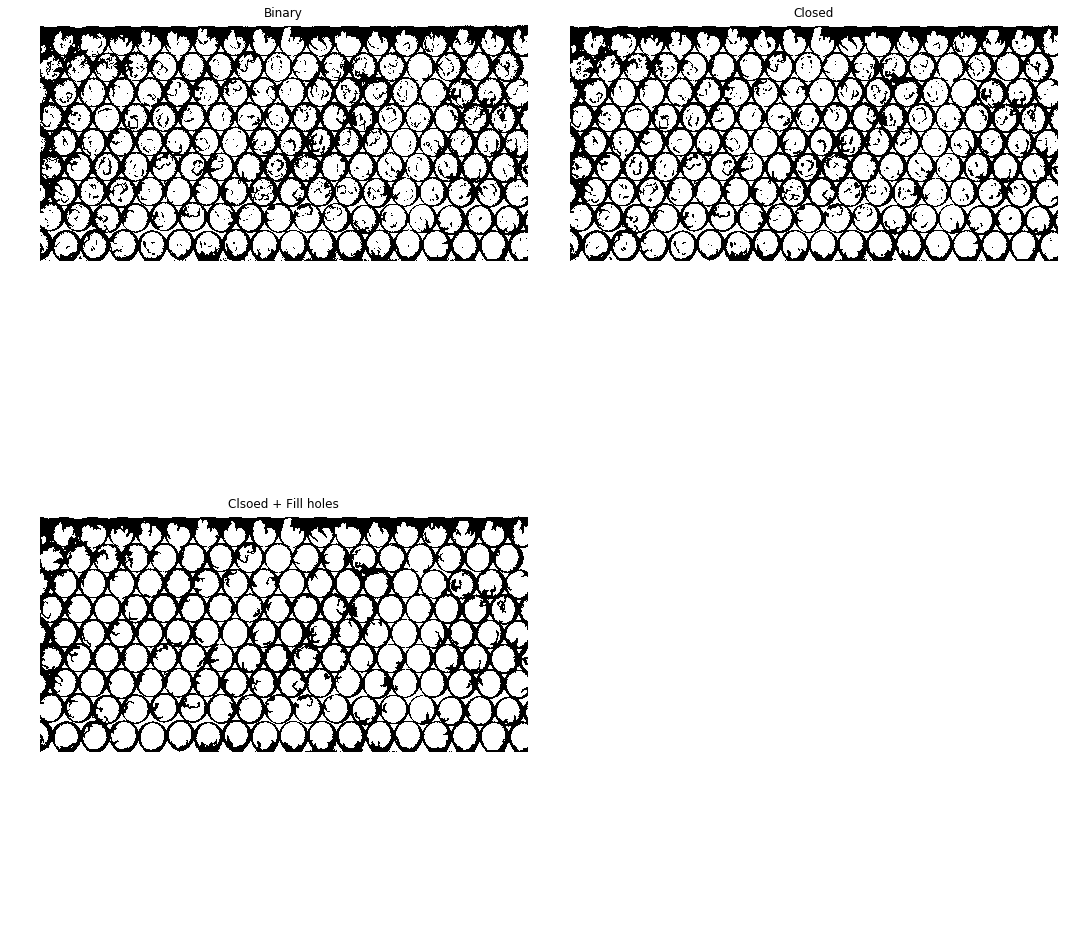

In [318]:
from skimage.morphology  import binary_closing, disk, binary_dilation, remove_small_holes, diameter_closing

# Remove dark spots and connect bright spots
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(4,4))
closed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations = 2)

# Fill holes 
fill_holes = ndi.morphology.binary_fill_holes(closed, structure=np.ones((3, 3))).astype('uint8')

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
ax = axes.ravel()

ax[0].imshow(binary, cmap=plt.cm.gray, interpolation='nearest')
ax[0].set_title('Binary')
ax[1].imshow(closed, cmap=plt.cm.gray, interpolation='nearest')
ax[1].set_title('Closed')
ax[2].imshow(fill_holes, cmap=plt.cm.gray, interpolation='nearest')
ax[2].set_title('Clsoed + Fill holes')

for a in ax:
    a.set_axis_off()

plt.tight_layout()
plt.show()

#### Sure foreground / background determination

In [319]:
def clear_border(image):
    h, w = image.shape
    mask = np.zeros((h + 2, w + 2), np.uint8)
    for i in range(h-1): # Iterate on the lines
        if image[i, 0] == 255:
            cv2.floodFill(image, mask, (0, i), 0)
        if image[i, w-1] == 255:
            cv2.floodFill(image, mask, (w-1, i), 0)
    for i in range(w-1): # Iterate on the columns
        if image[0, i] == 255:
            cv2.floodFill(image, mask, (i, 0), 0)
        if image[h-1, i] == 255:
            cv2.floodFill(image, mask, (i, h-1), 0)
    return image

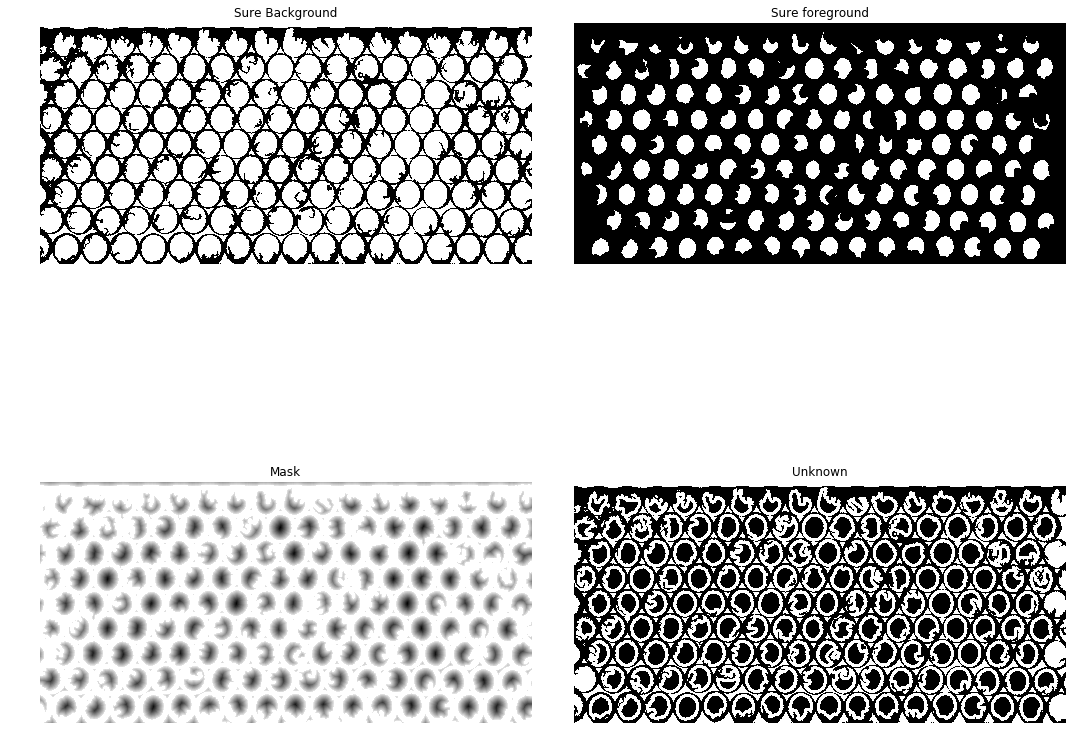

In [320]:
# sure background area
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
dilated = cv2.dilate(fill_holes,kernel,iterations=1)

#dist_transform = cv2.distanceTransform(fill_holes,cv2.DIST_L2,5)

#sure_bg = fill_holes.copy()
#sure_bg[(dist_transform != 0) & (dist_transform < 0.1*dist_transform.max())] = 0

sure_bg = np.uint8(dilated)

# Finding sure foreground area
dist_transform_fg = cv2.distanceTransform(fill_holes,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform_fg,0.25*dist_transform_fg.max(),255,0)
clear_border(sure_fg)

# Masking
mask = dist_transform.copy()
mask[mask < 10] = 0

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
ax = axes.ravel()

ax[0].imshow(sure_bg, cmap=plt.cm.gray, interpolation='nearest')
ax[0].set_title('Sure Background')
ax[1].imshow(sure_fg, cmap=plt.cm.gray, interpolation='nearest')
ax[1].set_title('Sure foreground')
ax[2].imshow(-mask, cmap=plt.cm.gray, interpolation='nearest')
ax[2].set_title('Mask')
ax[3].imshow(unknown, cmap=plt.cm.gray, interpolation='nearest')
ax[3].set_title('Unknown')

for a in ax:
    a.set_axis_off()

plt.tight_layout()
plt.show()

#### Label markers

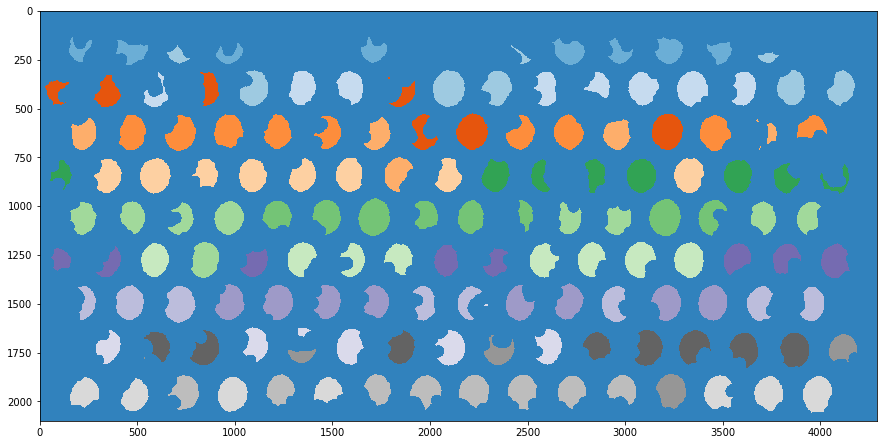

In [321]:
# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers+1

# Now, mark the region of unknown with zero
markers[unknown>0] = 0

fig = plt.figure(figsize=(15,10))
plt.imshow(markers, cmap=plt.cm.tab20c)

#### Run the watershed algorithm

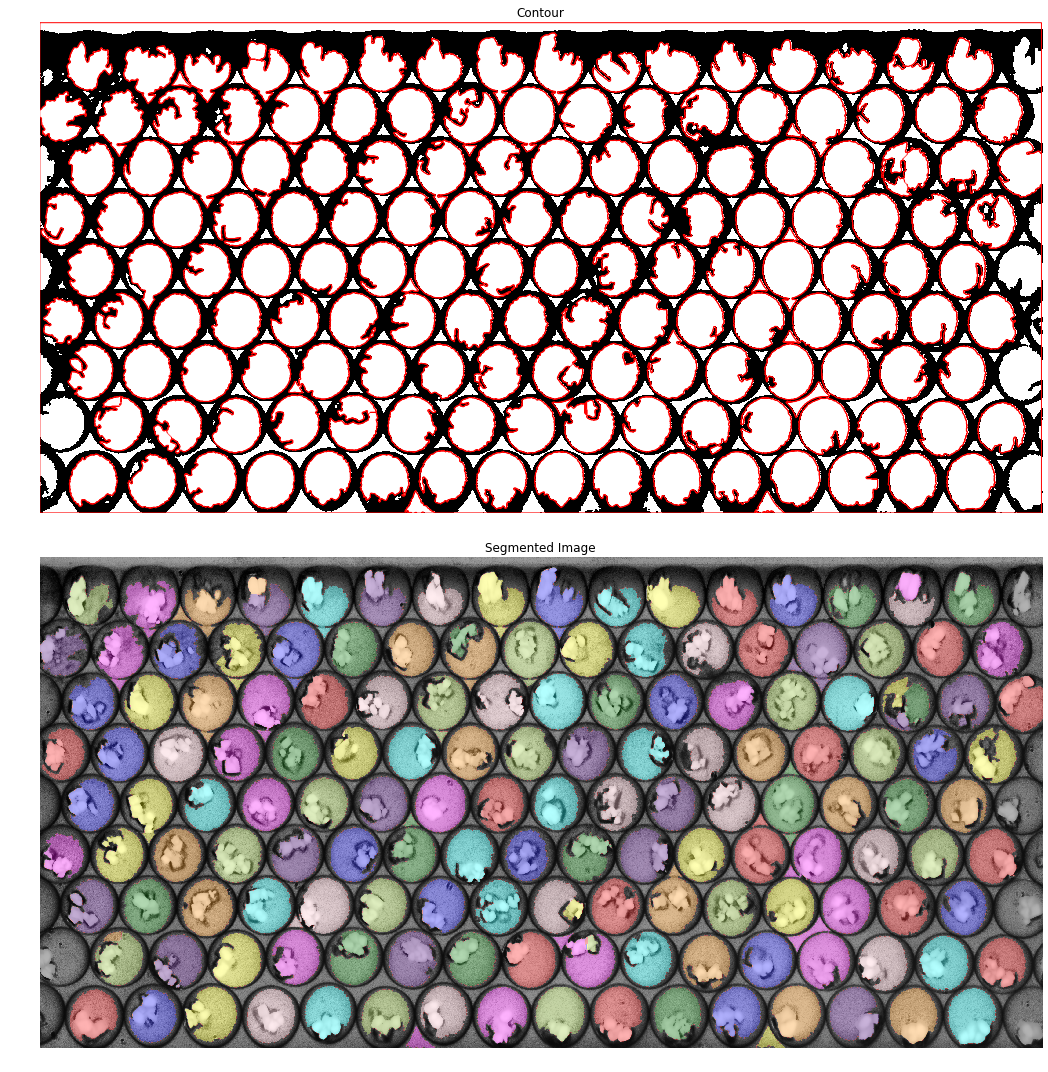

In [322]:
threeChannels = cv2.cvtColor(fill_holes, cv2.COLOR_GRAY2BGR)
segmented = cv2.watershed(threeChannels.astype('uint8'), markers)

# Color the labels sections for display
image_label_overlay = label2rgb(segmented, image=img_adapteq, bg_label=1)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))
ax = axes.ravel()

ax[0].imshow(fill_holes, cmap=plt.cm.gray, interpolation='nearest')
ax[0].contour(segmented, [0.5], linewidths=1, colors='r')
ax[0].set_title('Contour')
ax[1].imshow(image_label_overlay)
ax[1].set_title('Segmented Image')

for a in ax:
    a.set_axis_off()

plt.tight_layout()
plt.show()

In [323]:
segmented.max()

164

### Extract the labeled regions

In [365]:
segmented_bin = segmented.copy()
segmented_bin[segmented < 2] = 0
segmented_bin[segmented > 1] = 1
retval, labels, stats, centroids = cv2.connectedComponentsWithStats(segmented_bin.astype('uint8'), 4, cv2.CV_32S)

In [390]:
stats[1]

array([ 2116,    46,   206,   306, 32519], dtype=int32)

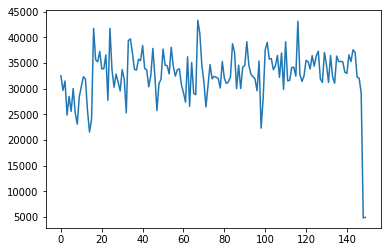

In [378]:
plt.plot(stats[1:, cv2.CC_STAT_AREA])

In [389]:
idx = 54
bbox = (stats[idx, cv2.CC_STAT_LEFT], stats[idx, cv2.CC_STAT_TOP], stats[idx, cv2.CC_STAT_LEFT] + stats[idx, cv2.CC_STAT_WIDTH], stats[idx, cv2.CC_STAT_TOP] + stats[idx, cv2.CC_STAT_HEIGHT])
area = stats[idx, cv2.CC_STAT_AREA]
print(f"Region #{idx} - Area {area} - Bbox {bbox}")

Region #54 - Area 32902 - Bbox (1985, 725, 2191, 955)


## QUESTION: How to get the eccentricity in OpenCV?

In [324]:
reg = regionprops(segmented, intensity_image=f_cropped, coordinates='rc')
columns= ['Label', 'Area', 'Eccentricity', 'Bbox Area', 'Bbox', 'Centroid', 'Image']
df = pd.DataFrame(columns=columns, dtype=np.float64)
df = df.append([{'Label':i.label, 'Area':i.area, 'Eccentricity':i.eccentricity, 'Bbox Area':i.bbox_area, 'Bbox':i.bbox, 'Centroid':i.centroid, 'Image':i.intensity_image} for i in reg])
df.head(5)

,Label,Area,Eccentricity,Bbox Area,Bbox,Centroid,Image
0,1.0,3954095.0,0.867070,8992028.0,"(1, 1, 2099, 4287)","(1013.5484577381171, 2148.085338111502)","[[129, 129, 128, 129, 131, 129, 127, 128, 130,..."
1,2.0,32519.0,0.713686,63036.0,"(46, 2116, 352, 2322)","(195.0940988345275, 2208.680248470125)","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,3.0,31506.0,0.685061,56883.0,"(65, 1872, 348, 2073)","(194.56640005078398, 1961.527740747794)","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,4.0,8978.0,0.577582,13794.0,"(67, 3656, 188, 3770)","(122.73824905324126, 3716.592336823346)","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,5.0,28509.0,0.486751,44550.0,"(67, 3881, 292, 4079)","(192.244063278263, 3976.9824266021255)","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


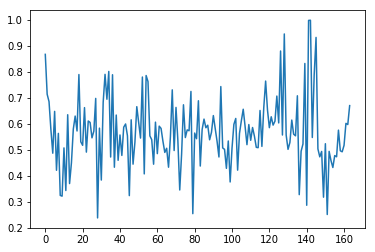

In [325]:
df.Eccentricity.plot()

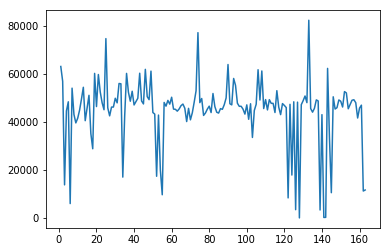

In [334]:
df.iloc[1:]['Bbox Area'].plot()

AttributeError: 'list' object has no attribute 'Area'

### Get individual images for each droplet

To be fed in the classification algorithm

#### Display images

164 drops where detected and segmented
156 clean drops with eccentricity < 0.8


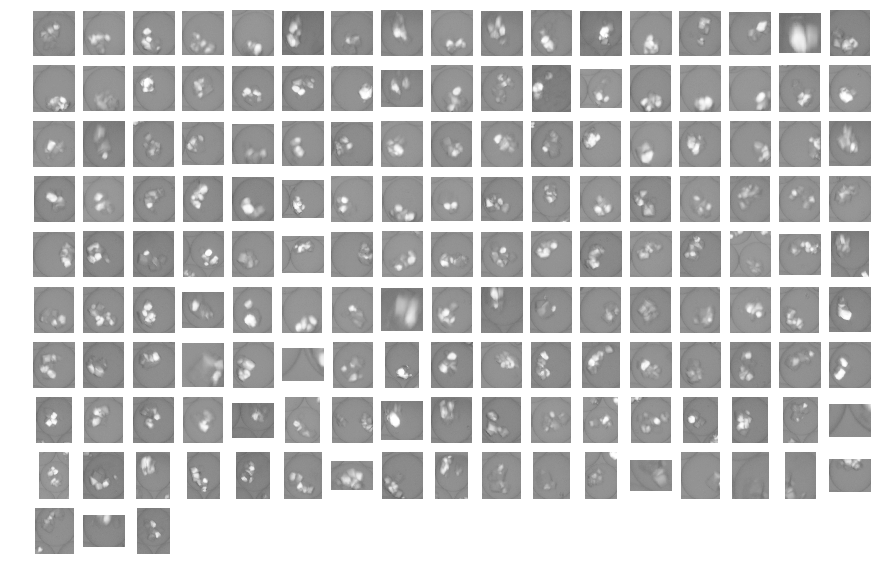

In [329]:
# Display parameters
org_img = f_cropped # Intensity image
border = 25 # Additional pixels to display on each side of the bounding box
ecc_cutoff = 0.8 # Eccentricity cuttoff, removes misidentified shapes (for instance half-droplets)
max_col = org_img.shape[1]
max_row = org_img.shape[0]

n_img = len(reg)
print("{} drops where detected and segmented".format(n_img))
n_col = 10
n_rows = n_img // n_col + 1

# Sort as a function of eccentricity
reg.sort(key=lambda x: x.eccentricity)
reg_clean = [region for region in reg if (region.eccentricity < ecc_cutoff)]

print("{} clean drops with eccentricity < {}".format(len(reg_clean), ecc_cutoff))

fig, ax = plt.subplots(n_col, n_rows)
axes = ax.ravel()

for i, region in enumerate(reg_clean):
    (min_row, min_col, max_row, max_col) = region.bbox
    drop_image = org_img[np.max([min_row-border,0]):np.min([max_row+border,max_row]),np.max([min_col-border,0]):np.min([max_col+border,max_col])]
    contrast_stretch = exposure.rescale_intensity(drop_image, in_range=(0,255))
    axes[i].imshow(contrast_stretch, cmap=plt.cm.gray, interpolation='nearest', vmin=0, vmax=255)
    axes[i].axis('off')
    
for i in range(n_col*n_rows - len(reg_clean)):
    axes[-(i+1)].axis('off')
    
fig.set_size_inches(15, 10)